This notebook will:
1. Visualize AI discourse volume over time by party
2. Calculate log-odds ratio to find distinctive words
3. Establish the "traditional" baseline (topic differences) that your semantic analysis will go beyond

# Cell 1: Setup & Load Data

In [1]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from collections import Counter

# Define paths
BASE_PATH = '/content/drive/MyDrive/same_words_different_worlds'

PATHS = {
    'raw': os.path.join(BASE_PATH, 'data/raw'),
    'processed': os.path.join(BASE_PATH, 'data/processed'),
    'outputs': os.path.join(BASE_PATH, 'data/outputs'),
    'models': os.path.join(BASE_PATH, 'models'),
    'figures': os.path.join(BASE_PATH, 'figures'),
}

# Load cleaned data
df = pd.read_csv(os.path.join(PATHS['processed'], '01_ai_tweets_clean.csv'))

# Convert posted_date back to datetime
df['posted_date'] = pd.to_datetime(df['posted_date'])

print(f"Loaded {len(df):,} AI-related tweets")
print(f"Date range: {df['posted_date'].min().date()} to {df['posted_date'].max().date()}")
print(f"Party distribution: D={len(df[df['party']=='D']):,}, R={len(df[df['party']=='R']):,}")

Mounted at /content/drive
Loaded 3,201 AI-related tweets
Date range: 2018-11-21 to 2024-11-20
Party distribution: D=2,022, R=1,179


# Cell 2: AI Discourse Volume by Year and Party

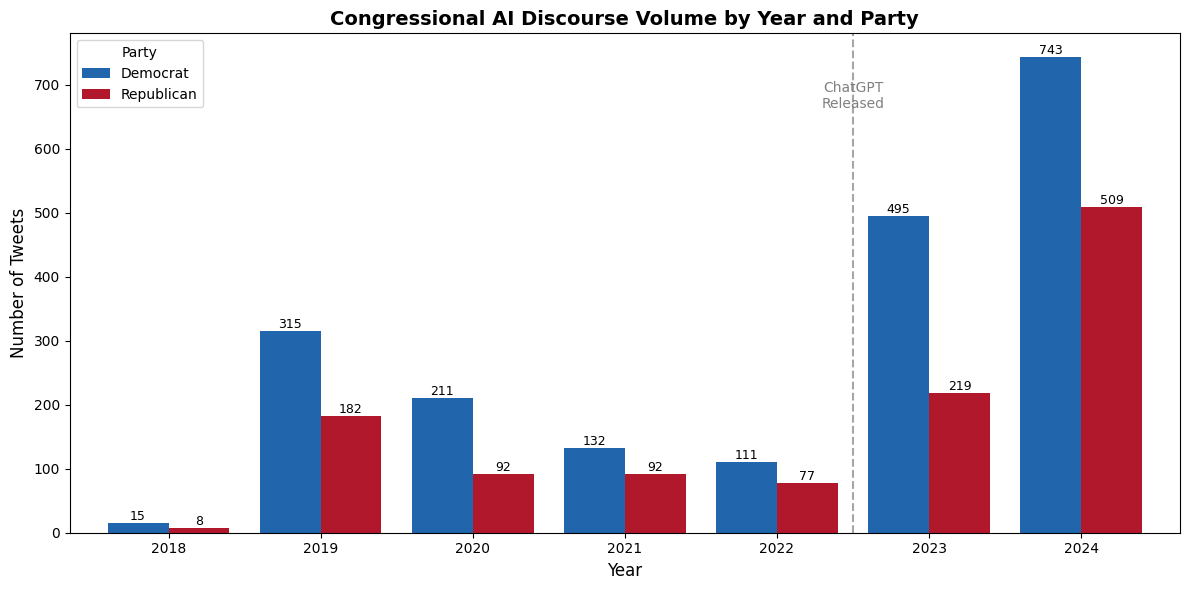


✓ Figure saved to: /content/drive/MyDrive/same_words_different_worlds/figures/01_volume_by_year.png

Exact counts:
party    D    R
year           
2018    15    8
2019   315  182
2020   211   92
2021   132   92
2022   111   77
2023   495  219
2024   743  509


In [2]:
# Create figure: AI Discourse Volume Over Time
fig, ax = plt.subplots(figsize=(12, 6))

# Count tweets by year and party
volume = df.groupby(['year', 'party']).size().unstack(fill_value=0)

# Plot
volume.plot(kind='bar', ax=ax, color={'D': '#2166AC', 'R': '#B2182B'}, width=0.8)

# Formatting
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Tweets', fontsize=12)
ax.set_title('Congressional AI Discourse Volume by Year and Party', fontsize=14, fontweight='bold')
ax.legend(title='Party', labels=['Democrat', 'Republican'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fontsize=9)

# Add annotation for ChatGPT release
ax.axvline(x=4.5, color='gray', linestyle='--', alpha=0.7)
ax.annotate('ChatGPT\nReleased', xy=(4.5, ax.get_ylim()[1]*0.85),
            fontsize=10, ha='center', color='gray')

plt.tight_layout()

# Save figure
save_path = os.path.join(PATHS['figures'], '01_volume_by_year.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved to: {save_path}")

# Print exact numbers
print("\nExact counts:")
print(volume)

Excellent visualization! The "ChatGPT effect" is dramatic—discourse exploded in 2023-2024. Also notable: Republicans nearly matched Democrats in 2024 (509 vs 743), suggesting AI became a bipartisan priority.

# Cell 3: Tokenization Function

In [3]:
# Define tokenization function for bag-of-words analysis
def tokenize(text):
    """
    Simple tokenizer for word frequency analysis.
    Lowercase, remove URLs, keep only letters.
    """
    if not isinstance(text, str):
        return []

    text = text.lower()
    text = re.sub(r'http\S+', '', text)        # Remove URLs
    text = re.sub(r'[^a-z\s]', '', text)       # Keep only letters
    tokens = text.split()

    return tokens

# Standard English stop words to exclude
STOP_WORDS = {
    'the', 'to', 'of', 'and', 'a', 'in', 'is', 'for', 'on', 'that', 'with',
    'are', 'as', 'be', 'our', 'we', 'it', 'this', 'by', 'at', 'has', 'will',
    'have', 'from', 'an', 'not', 'us', 'can', 'about', 'more', 'their', 'its',
    'was', 'been', 'would', 'they', 'or', 'but', 'all', 'so', 'if', 'what',
    'my', 'your', 'you', 'do', 'how', 'i', 'im', 'me', 'he', 'she', 'his',
    'her', 'who', 'which', 'when', 'where', 'there', 'these', 'those', 'than',
    'just', 'also', 'into', 'up', 'out', 'new', 'now', 'one', 'get', 'make'
}

# Test tokenizer
sample_text = "The AI revolution is transforming our economy! https://example.com"
print(f"Sample: '{sample_text}'")
print(f"Tokens: {tokenize(sample_text)}")

Sample: 'The AI revolution is transforming our economy! https://example.com'
Tokens: ['the', 'ai', 'revolution', 'is', 'transforming', 'our', 'economy']


Tokenizer working correctly. Now let's count words by party and calculate log-odds ratios.

# Cell 4: Calculate Log-Odds Ratio

In [4]:
# Count words per party
print("Counting words by party...")

tokens_d = []
tokens_r = []

for _, row in df.iterrows():
    tokens = tokenize(row['clean_text'])
    if row['party'] == 'D':
        tokens_d.extend(tokens)
    else:
        tokens_r.extend(tokens)

counts_d = Counter(tokens_d)
counts_r = Counter(tokens_r)

total_d = sum(counts_d.values())
total_r = sum(counts_r.values())

print(f"Total words (Democrat): {total_d:,}")
print(f"Total words (Republican): {total_r:,}")

# Calculate Smoothed Log-Odds Ratio
# Formula: log((count_D + 1) / (total_D + V)) - log((count_R + 1) / (total_R + V))
# Positive = More Democratic, Negative = More Republican

MIN_FREQUENCY = 15  # Minimum total occurrences to reduce noise
vocab = set(counts_d.keys()) | set(counts_r.keys())
V = len(vocab)  # Vocabulary size for smoothing

results = []
for word in vocab:
    freq_d = counts_d.get(word, 0)
    freq_r = counts_r.get(word, 0)

    # Skip rare words and stop words
    if freq_d + freq_r < MIN_FREQUENCY:
        continue
    if word in STOP_WORDS:
        continue

    # Smoothed log-odds
    log_odds = (np.log((freq_d + 1) / (total_d + V)) -
                np.log((freq_r + 1) / (total_r + V)))

    results.append({
        'word': word,
        'log_odds': log_odds,
        'freq_d': freq_d,
        'freq_r': freq_r,
        'total': freq_d + freq_r
    })

df_logodds = pd.DataFrame(results).sort_values('log_odds', ascending=False)

print(f"\nWords analyzed: {len(df_logodds)}")
print(f"\nTop 10 Democratic words:")
print(df_logodds.head(10)[['word', 'log_odds', 'freq_d', 'freq_r']])
print(f"\nTop 10 Republican words:")
print(df_logodds.tail(10)[['word', 'log_odds', 'freq_d', 'freq_r']])

Counting words by party...
Total words (Democrat): 71,088
Total words (Republican): 40,404

Words analyzed: 887

Top 10 Democratic words:
               word  log_odds  freq_d  freq_r
870           color  3.047760      33       0
204        intimate  2.888695      28       0
739           black  2.817236      53       1
201     unregulated  2.740275      24       0
26        deceptive  2.517131      39       1
285  discriminatory  2.354612      16       0
66   energycommerce  2.354612      16       0
246  discrimination  2.354612      16       0
754    unauthorized  2.354612      16       0
280         workers  2.174641      70       4

Top 10 Republican words:
              word  log_odds  freq_d  freq_r
803         beyond -1.657256       3      12
860      witnesses -1.731364       3      13
570         chinas -2.019046       2      13
6           victim -2.019046       2      13
109        chinese -2.029198       6      32
696            ccp -2.270360       2      17
400      commun

# cell 5: Visualize Log-Odds (Distinctive Words)

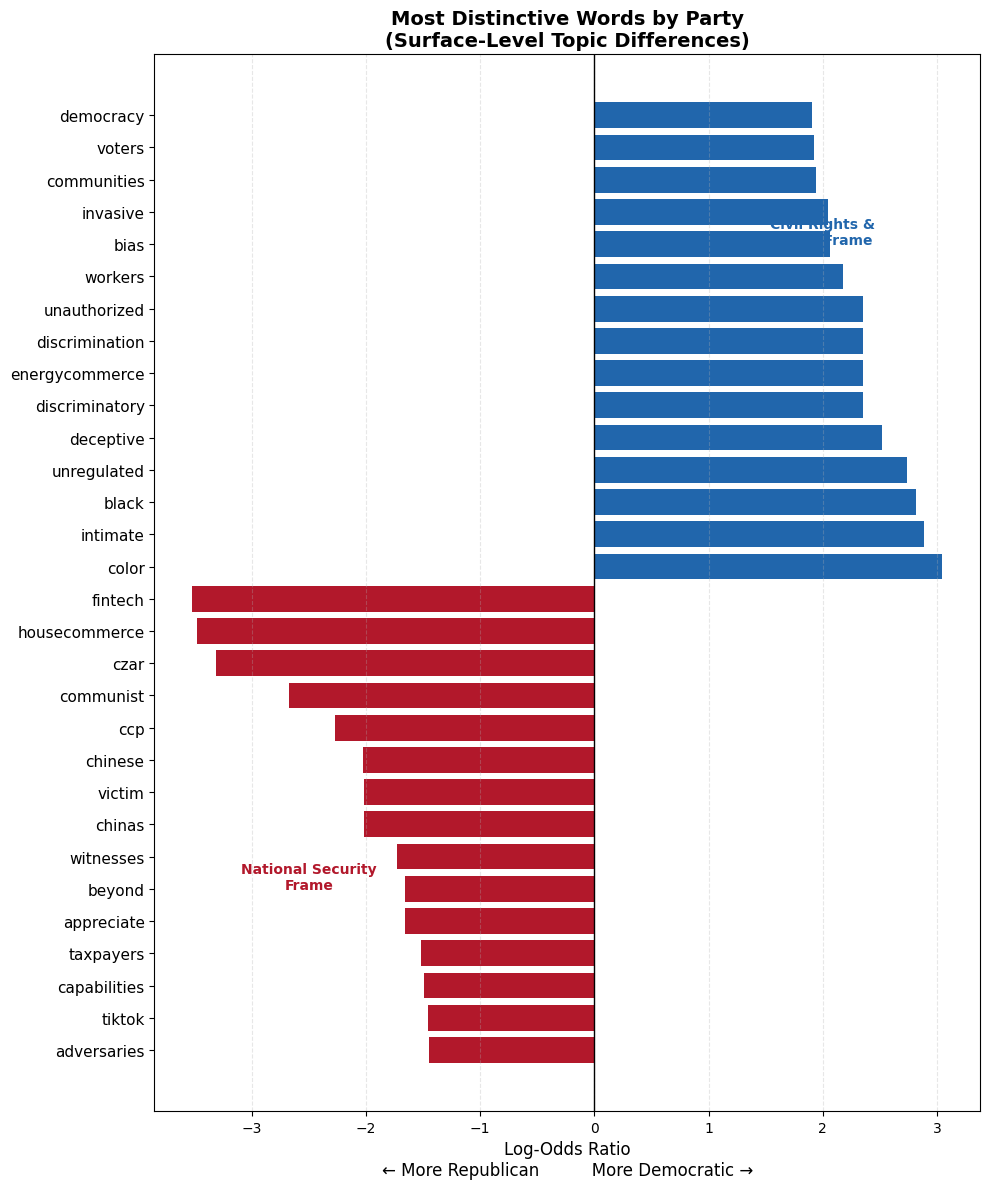


✓ Figure saved to: /content/drive/MyDrive/same_words_different_worlds/figures/02_log_odds_words.png


In [5]:
# Select top 15 words for each party
top_d = df_logodds.head(15).copy()
top_r = df_logodds.tail(15).copy()

# Combine for plotting
plot_data = pd.concat([top_r, top_d]).reset_index(drop=True)

# Create figure
fig, ax = plt.subplots(figsize=(10, 12))

# Color bars by direction
colors = ['#B2182B' if x < 0 else '#2166AC' for x in plot_data['log_odds']]

# Horizontal bar chart
bars = ax.barh(range(len(plot_data)), plot_data['log_odds'], color=colors)

# Add word labels
ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels(plot_data['word'], fontsize=11)

# Formatting
ax.axvline(0, color='black', linewidth=1)
ax.set_xlabel('Log-Odds Ratio\n← More Republican          More Democratic →', fontsize=12)
ax.set_title('Most Distinctive Words by Party\n(Surface-Level Topic Differences)',
             fontsize=14, fontweight='bold')

# Add grid for readability
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Annotations
ax.annotate('National Security\nFrame', xy=(-2.5, 5), fontsize=10,
            color='#B2182B', fontweight='bold', ha='center')
ax.annotate('Civil Rights &\nLabor Frame', xy=(2, 25), fontsize=10,
            color='#2166AC', fontweight='bold', ha='center')

plt.tight_layout()

# Save
save_path = os.path.join(PATHS['figures'], '02_log_odds_words.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved to: {save_path}")

This is a powerful visualization. The framing difference is stark:
* Democrats: civil rights, racial equity, labor (color, black, discrimination, workers, bias, communities)
* Republicans: national security, China threat (adversaries, tiktok, ccp, chinese, communist)

Now here's the key insight for our thesis: This shows topic differences. But what about words BOTH parties use? Let's find shared vocabulary.

# Cell 6: Identify Shared Words (Setup for Semantic Analysis)

In [6]:
# Find words that BOTH parties use frequently
# These are candidates for "same word, different meaning" analysis

MIN_FREQ_EACH = 10  # Must appear at least 10 times in EACH party's corpus

shared_words = []
for word in vocab:
    freq_d = counts_d.get(word, 0)
    freq_r = counts_r.get(word, 0)

    if freq_d >= MIN_FREQ_EACH and freq_r >= MIN_FREQ_EACH:
        if word not in STOP_WORDS:
            shared_words.append({
                'word': word,
                'freq_d': freq_d,
                'freq_r': freq_r,
                'total': freq_d + freq_r,
                'log_odds': df_logodds[df_logodds['word'] == word]['log_odds'].values[0]
                            if word in df_logodds['word'].values else 0
            })

df_shared = pd.DataFrame(shared_words).sort_values('total', ascending=False)

print("="*60)
print("SHARED VOCABULARY: Same Words, Different Meanings?")
print("="*60)
print(f"Words used frequently by BOTH parties: {len(df_shared)}")
print(f"\nTop 20 shared words (by total frequency):")
print(df_shared.head(20).to_string(index=False))

# Highlight key contested concepts
contested_concepts = ['safety', 'regulation', 'risk', 'rights', 'security',
                      'privacy', 'innovation', 'jobs', 'technology', 'protect']
print(f"\n\nKey contested concepts in shared vocabulary:")
for word in contested_concepts:
    if word in df_shared['word'].values:
        row = df_shared[df_shared['word'] == word].iloc[0]
        direction = "D-leaning" if row['log_odds'] > 0 else "R-leaning"
        print(f"  • {word}: D={row['freq_d']}, R={row['freq_r']} ({direction})")
    else:
        print(f"  • {word}: Not in shared vocabulary")

SHARED VOCABULARY: Same Words, Different Meanings?
Words used frequently by BOTH parties: 451

Top 20 shared words (by total frequency):
        word  freq_d  freq_r  total  log_odds
          ai    1584     855   2439  0.137468
  technology     383     174    557  0.307256
intelligence     256     289    545 -0.599406
  artificial     252     292    544 -0.625384
         amp     281     203    484 -0.154814
         act     284     154    438  0.130463
    robotics     225     147    372 -0.055278
        must     242      93    335  0.471166
         use     227      98    325  0.355625
  bipartisan     188     111    299  0.044647
        tech     212      80    292  0.488242
       today     184     101    285  0.116782
      ensure     181     101    282  0.100433
 recognition     237      44    281  1.187007
        work     171     107    278 -0.013238
      facial     230      45    275  1.135175
        need     199      67    266  0.600209
        bill     162     102    264

This is the foundation of our thesis. Look at those contested concepts:
* safety: D=85, R=28 — Democrats use it more, but what do they each mean by it?
* rights: D=66, R=17 — Same word, but civil rights vs. constitutional rights?
* security: D=103, R=101 — Nearly equal usage! Perfect candidate for semantic comparison.
* innovation: D=132, R=111 — Both value it, but in what context?

# Cell 7: EDA Summary & Save Key Data

In [7]:
# Save shared words list for later analysis
shared_words_path = os.path.join(PATHS['outputs'], 'shared_vocabulary.csv')
df_shared.to_csv(shared_words_path, index=False)

# Save log-odds results
logodds_path = os.path.join(PATHS['outputs'], 'log_odds_results.csv')
df_logodds.to_csv(logodds_path, index=False)

print("="*60)
print("NOTEBOOK 02 COMPLETE ✓")
print("="*60)
print("""
KEY FINDINGS FROM EDA:

1. VOLUME TRENDS:
   - AI discourse exploded post-ChatGPT (2023-2024)
   - Democrats tweet more about AI, but gap narrowing in 2024

2. SURFACE-LEVEL DIFFERENCES (Traditional View):
   - Democrats: civil rights, discrimination, workers, bias
   - Republicans: China, CCP, adversaries, national security
   → This is what existing research would find: DIFFERENT TOPICS

3. THE DEEPER QUESTION (Your Thesis):
   - 451 words used frequently by BOTH parties
   - Key contested concepts: safety, rights, security, innovation
   → Do these shared words have DIFFERENT MEANINGS?

4. CONTROL WORDS FOR VALIDATION:
   - "today" (D=184, R=101): Should have NO semantic difference
   - If contested words show higher divergence than controls,
     your thesis is supported.

Files saved:
""")
print(f"  • {shared_words_path}")
print(f"  • {logodds_path}")

print("""
NEXT STEPS:
  → Notebook 03: Fine-tune RoBERTa on AI discourse
  → Notebook 04: Extract embeddings
  → Notebook 05: Measure semantic distance for shared words
""")

NOTEBOOK 02 COMPLETE ✓

KEY FINDINGS FROM EDA:

1. VOLUME TRENDS:
   - AI discourse exploded post-ChatGPT (2023-2024)
   - Democrats tweet more about AI, but gap narrowing in 2024
   
2. SURFACE-LEVEL DIFFERENCES (Traditional View):
   - Democrats: civil rights, discrimination, workers, bias
   - Republicans: China, CCP, adversaries, national security
   → This is what existing research would find: DIFFERENT TOPICS

3. THE DEEPER QUESTION (Your Thesis):
   - 451 words used frequently by BOTH parties
   - Key contested concepts: safety, rights, security, innovation
   → Do these shared words have DIFFERENT MEANINGS?
   
4. CONTROL WORDS FOR VALIDATION:
   - "today" (D=184, R=101): Should have NO semantic difference
   - If contested words show higher divergence than controls,
     your thesis is supported.

Files saved:

  • /content/drive/MyDrive/same_words_different_worlds/data/outputs/shared_vocabulary.csv
  • /content/drive/MyDrive/same_words_different_worlds/data/outputs/log_odds_r